<a href="https://colab.research.google.com/github/vallimeenaav/Machine-Learning/blob/main/LINEAR_REGRESSION_CODE_FROM_SCRATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Linear regression (steps):
- inputs
- approach
- functions  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
df_housing = pd.read_csv('/content/housing.csv')
df_yacht = pd.read_csv('/content/yachtData.csv')
df_concrete = pd.read_csv('/content/concreteData.csv')

In [ ]:
X_housing = df_housing.values[:,:-1]
y_housing = df_housing.values[:,-1]

In [ ]:
X_yacht = df_yacht.values[:,:-1]
y_yacht = df_yacht.values[:,-1]

In [ ]:
X_concrete = df_concrete.values[:,:-1]
y_concrete = df_concrete.values[:,-1]

Class is a structure that can be re-used
- class of students
- class of cars, etc.

Two main parts: input parameters, series of functions that belong to that class

In [ ]:
class LinearRegression:

    def __init__(self, X, y, max_iteration, epsilon, learning_rate, gd,reg, sgd,reg_param) -> None:
        # input parameters; this function returns nothing (that's why we say None)
        # self means to globalize a parameter; making that function accessible from outside the class
        # tag every parameter (anywhere from outside the class also it'll be recognized)
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.gd = gd
        self.reg=reg
        self.sgd=sgd
        self.reg_param=reg_param

        # self.X: Feature matrix (X).
        # self.y: Target variable (y).
        # self.max_iteration: Maximum number of iterations for Gradient Descent (GD) or Stochastic Gradient Descent (SGD).
        # self.epsilon: Stopping criterion (smallest change in error for convergence).
        # self.learning_rate: Step size for GD/SGD.
        # self.gd: Boolean flag — True if using Gradient Descent.
        # self.reg: Boolean flag — True if using Regularization (Ridge Regression).
        # self.sgd: Boolean flag — True if using Stochastic Gradient Descent.
        # self.reg_param: Regularization parameter (λ for Ridge Regression).

    def data_split(self):
        self.trainX, self.testX, self.trainy, self.testy = train_test_split(self.X,
                                                                            self.y,
                                                                            test_size = 0.3)
        # 30% test and 70% train

    def add_X0(self, X):
        return np.column_stack([np.ones(X.shape[0]),X])

        # Adds a bias term (intercept) by appending a column of 1s to X.

    def train_scaling(self, X):
        mean = np.mean(X, axis=0) #axis 0 is vertical, for columns)
        std = np.std(X, axis=0)
        X = (X - mean) / std
        X = self.add_X0(X)
        return X, mean, std

    def test_scaling(self, X, mean, std):
        X = (X - mean) / std
        X = self.add_X0(X)
        return X

    def rank(self, X):
        v, s, u = np.linalg.svd(X)  # singular value decomposition
        rank = np.sum(s>0.00001)  # s is an array of eigen values and we need all non-zero eigen values

        rank = np.linalg.matrix_rank(X)
        return rank

    def full_rank(self,X):
        # minimum of n and d should be equal to rank for it to be a full rank
        rank = self.rank(X)
        if rank == min(X.shape):
          self.fullRank = True
          print("Data is Full Rank")
        else:
          self.fullRank = False
          print("Data is not Full Rank")

    def low_rank(self, X):
        if X.shape[0] < X.shape[1]: # n<d
          self.lowRank = True
          print("Data is low Rank")
        else:
          self.lowRank = False
          print("Data is not low Rank")

    def closed_form_solution(self, X, y):
        if self.reg == False:
          w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)   # optimal theeta
        else:
          w = np.linalg.inv((X.T.dot(X)) + self.reg_param * np.eye(X.shape[1])).dot(X.T).dot(y)
        return w


    def predict(self, X):
      return X.dot(self.w) # this is y bar

    def rmse(self, X, y):
        # for norm 2
        y_hat = self.predict(X)
        return(((((y_hat - y)**2).sum())/X.shape[0])**0.5)
        # RMSE has the same units as the target variable (y), making it easier to interpret.

    def sse(self,X,y):
      y_hat = self.predict(X)
      return(sum((y_hat - y)**2))
      # This gives the total error across all predictions.

    def cost_function(self, X, y):
        loss = self.rmse(X,y)
        return loss / 2
        # Dividing by 2 is a common mathematical trick in optimization.
        # Reason? The derivative of squared loss will have a factor of 2 in the numerator.
        # Scaling by 1/2 cancels this out, simplifying calculations in Gradient Descent.

    def cost_derivative(self, X, y):
        y_hat = self.predict(X)
        if self.reg == False:
          return X.T.dot(y_hat - y)
        else:
          return (X.T.dot(y_hat - y) + (self.reg_param * self.w))

    def gradient_descent(self, X, y):
        errors = [] # placeholder for each error in every iteration
        prev_error = float("inf")
        for t in tqdm(range(self.max_iteration), colour = 'blue'): # tqdm is a library being used to show progress bar that shows percentage
          self.w -= self.learning_rate * self.cost_derivative(X, y)
          loss = self.rmse(X, y)
          errors.append(loss)
          if abs(loss - prev_error) < self.epsilon:
            print("Model stopped learning")
            break
          prev_error = loss
        print('Training Error (RMSE) : ',prev_error)
        plt.plot(errors)
        plt.title('Error vs epoch')
        plt.xlabel('epoches')
        plt.ylabel('error')
        plt.show()
        # self.plot_rmse(errors)

    def stochastic_gd(self,X, y):
        # Initialize weights and bias
        num_features = X.shape[1]
        errors = [] # placeholder for each error in every iteration
        prev_error = float("inf")
        for j in tqdm(range(self.max_iteration),colour='blue'):
          indices = np.random.permutation(len(X))
          X_shuffled = X[indices]
          y_shuffled = y[indices]

          epoch_error=[]
          for i in range(0, len(X)):
                  # Get batch
              X_batch = X_shuffled[i:i+ 1]
              y_batch = y_shuffled[i:i+ 1]

                  # Update weights and bias
              self.w -= self.learning_rate * self.cost_derivative(X_batch,y_batch)
              batch_loss= self.rmse(X_batch,y_batch)
              epoch_error.append(batch_loss)
          loss=sum(epoch_error)/len(epoch_error)
          errors.append(loss)
          if abs(loss - prev_error) < self.epsilon:
            print("Model stopped learning")
            break
          prev_error = loss
        print('Training Error (RMSE) : ',prev_error)
        plt.plot(errors)
        plt.title('Error vs epoch')
        plt.xlabel('epoches')
        plt.ylabel('error')
        plt.show()


    def fit(self):
        self.data_split()
        self.trainX, mean, std = self.train_scaling(self.trainX)
        self.testX = self.test_scaling(self.testX, mean, std)

        self.full_rank(self.trainX)
        self.low_rank(self.trainX)
        if self.sgd:
          print('Solving Using Stochastic Gradient Descent')
          self.w = np.zeros(self.trainX.shape[1],dtype = np.float64)*0
          self.stochastic_gd(self.trainX,self.trainy)
        elif self.fullRank and not self.lowRank and self.trainX.shape[1] < 1000 and not self.gd and not self.sgd:
          print("solved using closed form solution")
          self.w=self.closed_form_solution(self.trainX, self.trainy)
          print('Training Error (RMSE) : ',self.rmse(self.trainX,self.trainy))
        else:
          print("solved using gradient descent")
          self.w = np.zeros(self.trainX.shape[1],dtype = np.float64)*0
          self.b = self.gradient_descent(self.trainX, self.trainy)


        print(self.w)
        print('Testing Error [SSE]: ',self.sse(self.testX,self.testy))
        print('Testing Error [RMSE]: ',self.rmse(self.testX,self.testy))

  #  def metrics(self):
  #    print('Testing Error [RMSE]: ',self.rmse(self.testX,self.testy))




    # def plot_rmse(self, error_sequence):
    #     """
    #     @X: error_sequence, vector of rmse
    #     @does: Plots the error function
    #     @return: plot
    #     """
    #     # Data for plotting
    #     s = np.array(error_sequence)
    #     t = np.arange(s.size)

    #     fig, ax = plt.subplots()
    #     ax.plot(t, s)

    #     ax.set(xlabel='iterations', ylabel=self.error,
    #            title='{} trend'.format(self.error))
    #     ax.grid()

    #     plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
    #     plt.show()



In [ ]:
lr_housing_clr = LinearRegression(X_housing, y_housing, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000,gd=False,reg=False,sgd=False,reg_param=0.01)
lr_housing_clr_reg = LinearRegression(X_housing, y_housing, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000,gd=False,reg=False,sgd=False,reg_param=0.01)
lr_housing_gd = LinearRegression(X_housing, y_housing, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000,gd=True,reg=False,sgd=False,reg_param=0.01)
lr_housing_gd_reg = LinearRegression(X_housing, y_housing, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000,gd=True,reg=True,sgd=False,reg_param=0.01)
lr_housing_sgd = LinearRegression(X_housing, y_housing, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000,gd=True,reg=False,sgd=True,reg_param=0.01)
lr_housing_sgd_reg = LinearRegression(X_housing, y_housing, learning_rate = 0.0004, epsilon = 0.005, max_iteration = 50000,gd=True,reg=True,sgd=True,reg_param=0.01)


In [ ]:
lr_yacht_clr = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = False,reg=False,sgd=False,reg_param=0.01)
lr_yacht_clr_reg = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = False,reg=True,sgd=False,reg_param=0.01)
lr_yacht_gd = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=False,sgd=False,reg_param=0.01)
lr_yacht_gd_reg = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=True,sgd=False,reg_param=0.01)
lr_yacht_sgd = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=False,sgd=True,reg_param=0.01)
lr_yacht_sgd_reg = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=True,sgd=True,reg_param=0.01)

In [ ]:
lr_concrete_clr = LinearRegression(X_concrete, y_concrete, learning_rate = 0.0007, epsilon = 0.0001, max_iteration = 50000, gd = False,reg=False,sgd=False,reg_param=0.01)
lr_concrete_clr_reg = LinearRegression(X_concrete, y_concrete, learning_rate = 0.0007, epsilon = 0.0001, max_iteration = 50000, gd = False,reg=True,sgd=False,reg_param=0.01)
lr_concrete_gd = LinearRegression(X_concrete, y_concrete, learning_rate = 0.0007, epsilon = 0.0001, max_iteration = 50000, gd = True,reg=False,sgd=False,reg_param=0.01)
lr_concrete_gd_reg = LinearRegression(X_concrete, y_concrete, learning_rate = 0.0007, epsilon = 0.0001, max_iteration = 50000, gd = True,reg=True,sgd=False,reg_param=0.01)
lr_concrete_sgd = LinearRegression(X_concrete, y_concrete, learning_rate = 0.0007, epsilon = 0.0001, max_iteration = 50000, gd = False,reg=False,sgd=True,reg_param=0.01)
lr_concrete_sgd_reg = LinearRegression(X_concrete, y_concrete, learning_rate = 0.0007, epsilon = 0.0001, max_iteration = 50000, gd = False,reg=True,sgd=True,reg_param=0.01)

In [ ]:
lr_housing_clr.fit()
#lr_housing_clr.metrics()

Data is Full Rank
Data is not low Rank
solved using closed form solution
Training Error (RMSE) :  4.369941439218554
[ 2.20770538e+01 -4.98416182e-01  9.80195060e-01  3.33975209e-03
  7.86949054e-01 -1.51023632e+00  2.68645914e+00 -8.75240810e-02
 -2.86288485e+00  2.34061785e+00 -2.10058191e+00 -1.79097907e+00
  9.90505853e-01 -3.70797743e+00]
Testing Error [SSE]:  4404.877186710461
Testing Error [RMSE]:  5.383256930123873


In [ ]:
lr_housing_clr_reg.fit()

Data is Full Rank
Data is not low Rank
solved using closed form solution
Training Error (RMSE) :  4.725535618822779
[22.65835694 -0.45426571  0.8819484   0.15936166  0.60592235 -2.10646921
  2.75825277  0.42793448 -2.76524752  2.34466526 -1.95683546 -2.0428356
  0.87430467 -4.10897036]
Testing Error [SSE]:  3267.6462116736257
Testing Error [RMSE]:  4.636558254268054


Data is Full Rank
Data is not low Rank
solved using gradient descent


  0%|          | 30/50000 [00:00<00:02, 18856.45it/s]

Model stopped learning
Training Error (RMSE) :  4.756384423925049


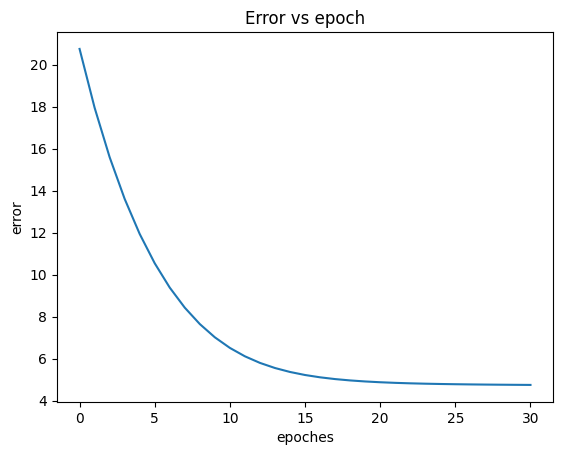

[22.59873503 -0.81003948  0.19406406 -0.37930698  1.09870394 -0.91041025
  3.29462185 -0.33380795 -1.89069701  1.00919598 -0.41749567 -1.82022529
  0.57220275 -3.66448211]
Testing Error [SSE]:  3754.5052184683523
Testing Error [RMSE]:  4.969979097216153


In [ ]:
lr_housing_gd.fit()

Data is Full Rank
Data is not low Rank
solved using gradient descent


  0%|          | 31/50000 [00:00<00:12, 4130.88it/s]

Model stopped learning
Training Error (RMSE) :  4.801364386940952


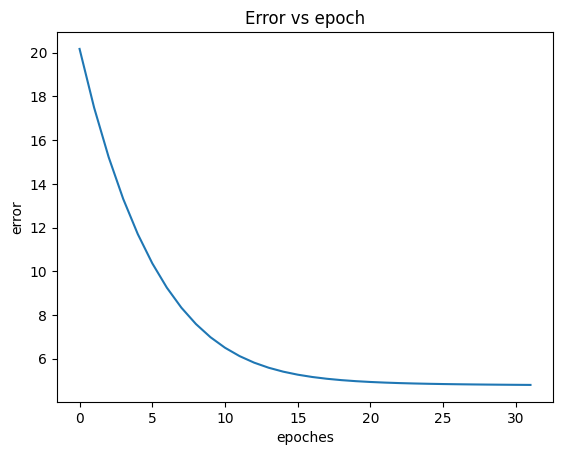

[21.97469064 -0.96735416  0.67474867 -0.237115    1.03109423 -0.98158715
  3.01053797  0.13454801 -1.90239425  1.13004331 -0.17961996 -1.58540181
  0.94015865 -3.73984289]
Testing Error [SSE]:  3556.340368384867
Testing Error [RMSE]:  4.837042082491651


In [ ]:
lr_housing_gd_reg.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 23/50000 [00:00<08:26, 98.58it/s] 


Model stopped learning
Training Error (RMSE) :  3.1322715455646786


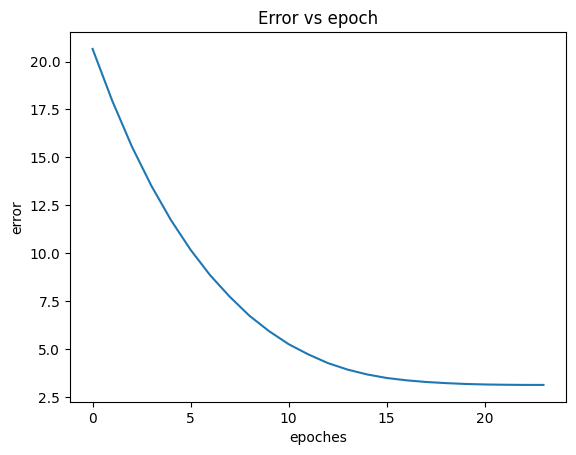

[21.48674193 -0.57206345  0.26044931 -0.55337153  0.68000507 -0.87156703
  2.85891404 -0.4476129  -1.68734419  0.62371933 -0.4636778  -1.67052665
  0.78148741 -2.9289941 ]
Testing Error [SSE]:  4324.4702558229255
Testing Error [RMSE]:  5.33389746895845


In [ ]:
lr_housing_sgd.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 25/50000 [00:00<09:28, 87.97it/s]


Model stopped learning
Training Error (RMSE) :  3.106484591169082


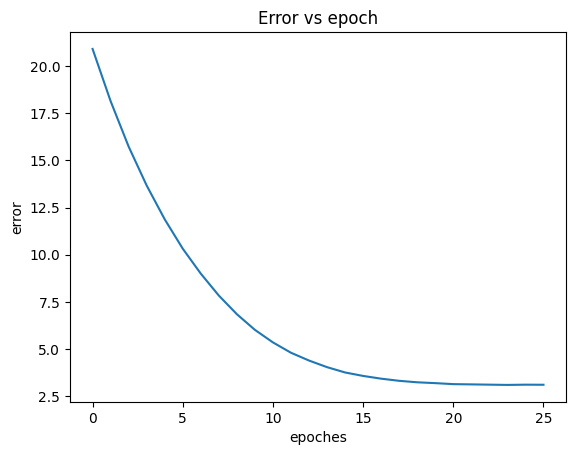

[21.70892782 -0.46329012  0.59169712 -0.39825728  1.11992089 -0.80244708
  3.20065771 -0.13561231 -1.83474303  0.61543356 -0.55344083 -1.71605297
  0.96466278 -3.22353549]
Testing Error [SSE]:  4009.032727239815
Testing Error [RMSE]:  5.135680608331116


In [ ]:
lr_housing_sgd_reg.fit()

In [ ]:
lr_yacht_clr.fit()

Data is Full Rank
Data is not low Rank
solved using closed form solution
Training Error (RMSE) :  8.130957962755824
[ 9.2361215   0.33317108 -1.27297463 -2.95746425  2.54635945  2.72168286
 10.94844368]
Testing Error [SSE]:  10497.064647091944
Testing Error [RMSE]:  10.62410762708833


In [ ]:
lr_yacht_clr_reg.fit()

Data is Full Rank
Data is not low Rank
solved using closed form solution
Training Error (RMSE) :  8.76637269481621
[10.24648381  0.3589391  -0.63492754  0.73795593 -0.41214007 -1.20362036
 12.01232234]
Testing Error [SSE]:  7764.516720783047
Testing Error [RMSE]:  9.137254899869768


Data is Full Rank
Data is not low Rank
solved using gradient descent


  0%|          | 19/50000 [00:00<00:12, 3959.45it/s]

Model stopped learning
Training Error (RMSE) :  8.949792776143926


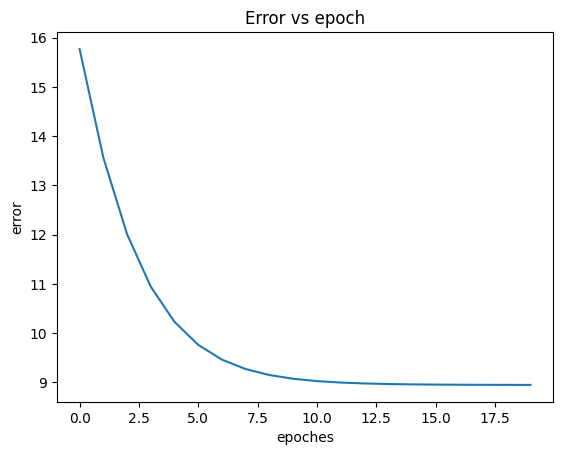

[10.81635198  0.11249783 -0.32548082 -0.62694597 -0.12001685 -0.20559238
 12.29592601]
Testing Error [SSE]:  7148.899842706106
Testing Error [RMSE]:  8.767547592216772


In [ ]:
lr_yacht_gd.fit()

Data is Full Rank
Data is not low Rank
solved using gradient descent


  0%|          | 18/50000 [00:00<00:05, 8565.63it/s]

Model stopped learning
Training Error (RMSE) :  8.655530054251244


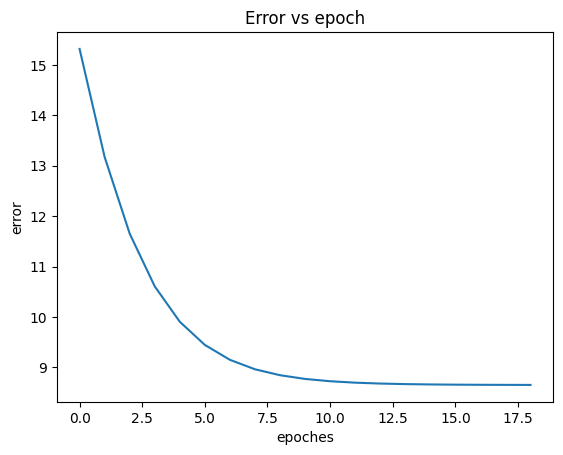

[10.37705313  1.18421624 -0.63479337 -0.18387563 -0.22031455 -0.012149
 11.98485942]
Testing Error [SSE]:  8482.290014022457
Testing Error [RMSE]:  9.550257562265942


In [ ]:
lr_yacht_gd_reg.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 30/50000 [00:00<06:06, 136.30it/s]


Model stopped learning
Training Error (RMSE) :  7.139455889936172


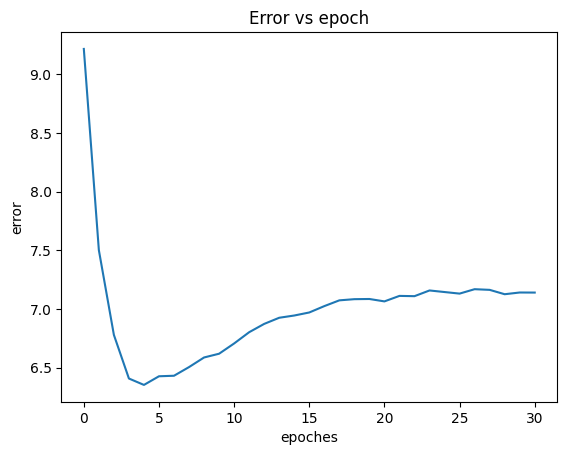

[ 1.02849992e+01  5.50894485e-02 -7.04111690e-01  5.38455523e-01
  6.42948104e-03  2.08522442e-01  1.23002368e+01]
Testing Error [SSE]:  7273.4835047536835
Testing Error [RMSE]:  8.843613517737808


In [ ]:
lr_yacht_sgd.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 87/50000 [00:00<05:07, 162.43it/s]


Model stopped learning
Training Error (RMSE) :  7.369517395888201


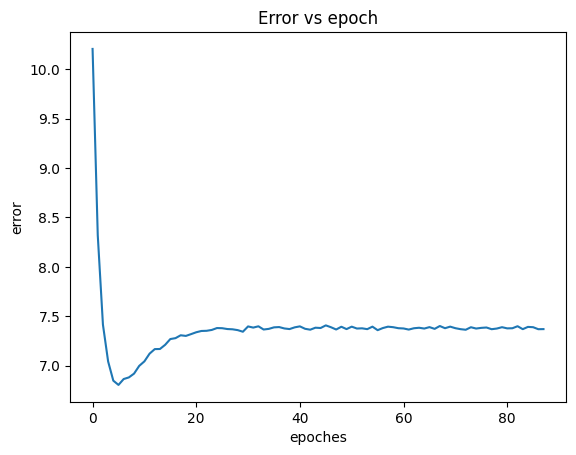

[11.29355593  0.61464352  0.2683568   0.10817065 -0.53682533 -0.31763089
 12.97933391]
Testing Error [SSE]:  6804.20237314998
Testing Error [RMSE]:  8.553564542221961


In [ ]:
lr_yacht_sgd_reg.fit()

In [ ]:
lr_concrete_clr.fit()

Data is Full Rank
Data is not low Rank
solved using closed form solution
Training Error (RMSE) :  10.812108603004031
[36.07748611 12.75151565  9.53386865  6.28412602 -2.6165812   1.42183806
  2.08967921  2.37055741  7.54944095]
Testing Error [SSE]:  26051.959151990315
Testing Error [RMSE]:  9.182077510969096


In [ ]:
lr_concrete_clr_reg.fit()

Data is Full Rank
Data is not low Rank
solved using closed form solution
Training Error (RMSE) :  10.062468872577
[35.54803406 12.47511073  8.42272393  5.39019209 -2.8330839   2.30063943
  1.49899414  1.56492309  7.10130069]
Testing Error [SSE]:  37162.064822850305
Testing Error [RMSE]:  10.966566552525542


Data is Full Rank
Data is not low Rank
solved using gradient descent


  0%|          | 146/50000 [00:00<00:04, 12194.93it/s]

Model stopped learning
Training Error (RMSE) :  10.051689676387745


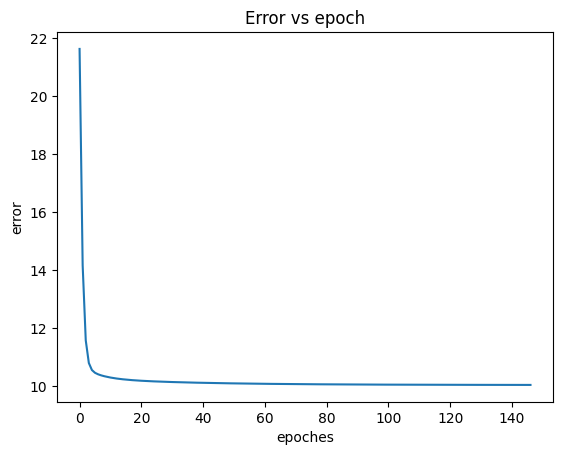

[36.05019444 12.74197332  9.32038844  6.05721378 -3.7239752   1.1277678
  0.92016211  1.62768689  7.19240412]
Testing Error [SSE]:  37531.17606956206
Testing Error [RMSE]:  11.020894552166551


In [ ]:
lr_concrete_gd.fit()

Data is Full Rank
Data is not low Rank
solved using gradient descent


  0%|          | 138/50000 [00:00<00:05, 9948.85it/s]

Model stopped learning
Training Error (RMSE) :  10.369489838121222


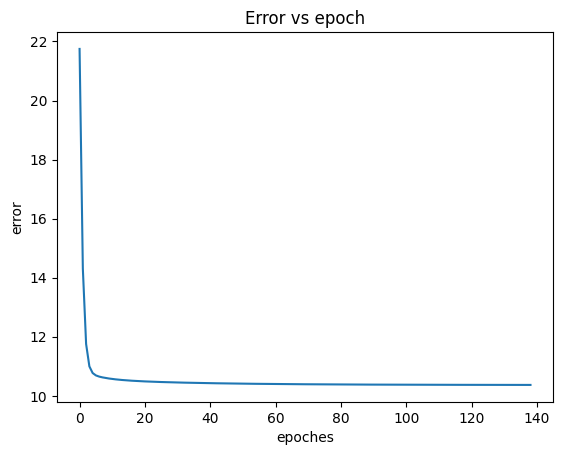

[36.25278816 12.27562351  8.27664507  4.8941092  -3.30465295  2.38639441
  1.2158481   1.51580594  6.96968387]
Testing Error [SSE]:  32931.660147033544
Testing Error [RMSE]:  10.323514514551105


In [ ]:
lr_concrete_gd_reg.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 101/50000 [00:00<07:37, 109.02it/s]


Model stopped learning
Training Error (RMSE) :  8.367454252269821


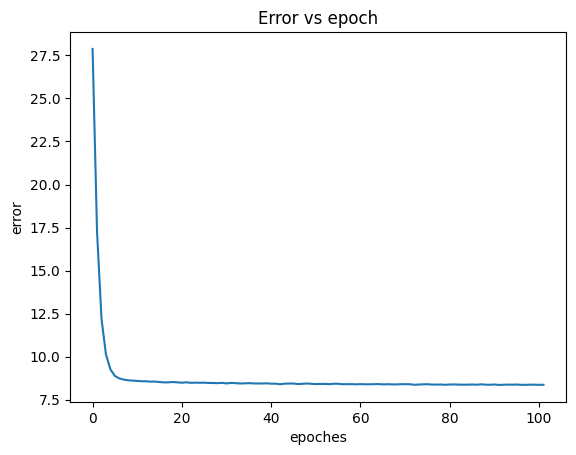

[35.6037459  11.74554729  7.84423692  4.84271814 -3.60331966  1.82121054
  0.96049203  0.90193087  7.16297565]
Testing Error [SSE]:  30727.049970612054
Testing Error [RMSE]:  9.971975289130498


In [ ]:
lr_concrete_sgd.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 96/50000 [00:01<08:46, 94.79it/s]


Model stopped learning
Training Error (RMSE) :  8.168392884496477


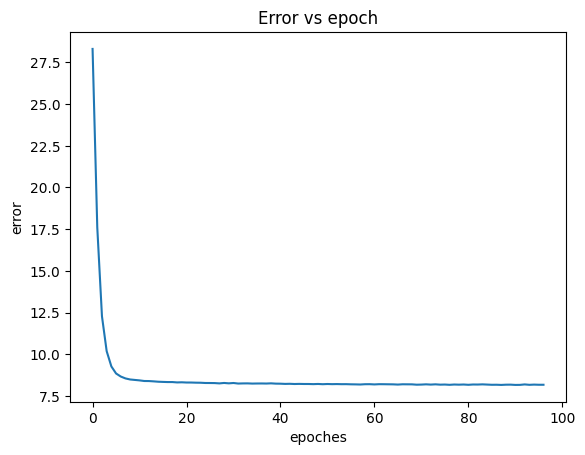

[35.87014074 10.95176786  7.1543141   4.18838251 -4.6336864   1.67924217
  0.35111424  0.2887104   6.86215979]
Testing Error [SSE]:  35971.409966754596
Testing Error [RMSE]:  10.789454573308937


In [ ]:
lr_concrete_sgd_reg.fit()

**Observations:**

For housing dataset, regularized closed room solution, with regularization parameter = 0.01 gives the least test error.

For yacht dataset, stochastic gradient descent with regularization parameter = 0.01 and learning rate = 0.001 gives the least test error.

For concrete dataset, closed room solution gives the least test error.

**Changing the regulariation parameter:**

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 25/50000 [00:00<04:31, 184.20it/s]

Model stopped learning
Training Error (RMSE) :  7.128137650845635


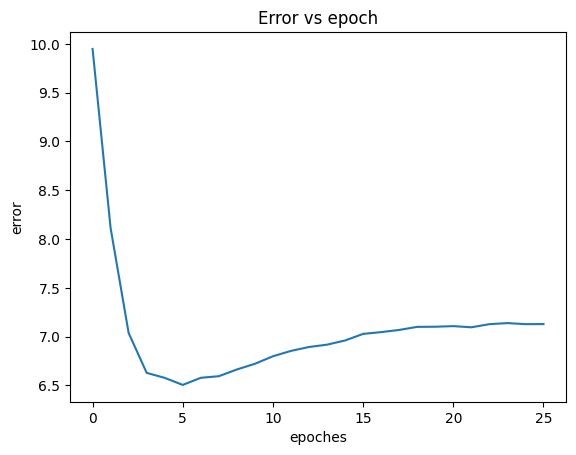

[11.05661899  0.02741951 -0.09178669  0.0991855   0.13245576 -0.28154151
 12.62825456]
Testing Error [SSE]:  7810.182386586658
Testing Error [RMSE]:  9.164085102712056


In [ ]:
lr_yacht_sgd_reg_0001 = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=True,sgd=True,reg_param=0.0001)
lr_yacht_sgd_reg_0001.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 62/50000 [00:00<02:58, 280.43it/s]


Model stopped learning
Training Error (RMSE) :  7.225648097529351


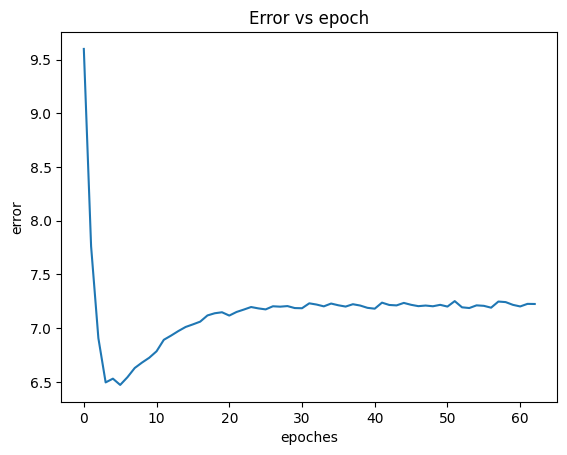

[10.6101362   0.61693078  0.06661497 -0.35297445 -0.59161153 -0.08746637
 12.67524903]
Testing Error [SSE]:  7255.63939883041
Testing Error [RMSE]:  8.832758795779098


In [ ]:
lr_yacht_sgd_reg_001 = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=True,sgd=True,reg_param=0.001)
lr_yacht_sgd_reg_001.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 31/50000 [00:00<03:57, 210.42it/s]

Model stopped learning
Training Error (RMSE) :  6.637568184141967


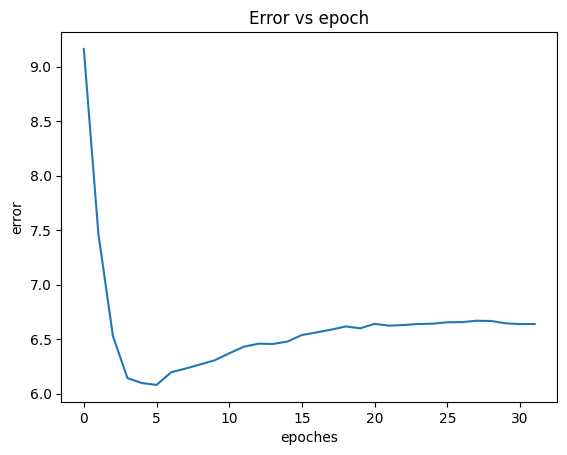

[10.07748006  0.59919349 -0.365017    0.14775659 -0.09498329  0.05127549
 11.48563358]
Testing Error [SSE]:  9208.991594483114
Testing Error [RMSE]:  9.950950456837884


In [ ]:
lr_yacht_sgd_reg_01 = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=True,sgd=True,reg_param=0.01)
lr_yacht_sgd_reg_01.fit()

Data is Full Rank
Data is not low Rank
Solving Using Stochastic Gradient Descent


  0%|          | 25/50000 [00:00<04:14, 196.54it/s]

Model stopped learning
Training Error (RMSE) :  6.748790791166128


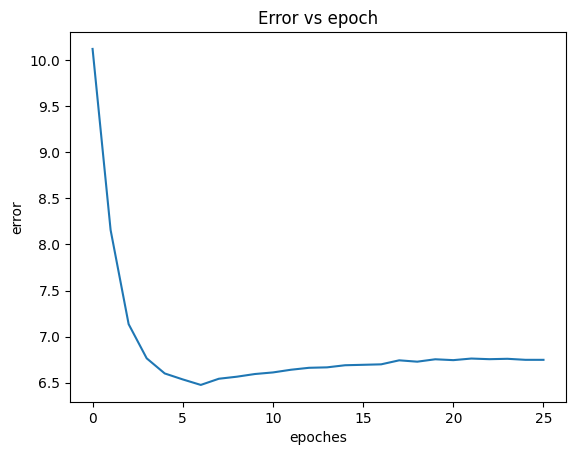

[ 1.01649415e+01  6.66357565e-01 -1.85543984e-02 -8.16910481e-03
 -5.09107242e-01  3.18227597e-01  1.13012040e+01]
Testing Error [SSE]:  7851.7615326001915
Testing Error [RMSE]:  9.188446188626909


In [ ]:
lr_yacht_sgd_reg_1 = LinearRegression(X_yacht, y_yacht, learning_rate = 0.001, epsilon = 0.001, max_iteration = 50000, gd = True,reg=True,sgd=True,reg_param=0.1)
lr_yacht_sgd_reg_1.fit()

**Observations by varying reg param in the Yatch dataset:**

From the yatch dataset, by varying the regularization parameter, we do not see a constant incline or decline in the testing errors. But we observed the least error for regularization parameter = 0.0001.

**Conclusion**:

* Regularization prevents overfitting by adjusting the "lambda"
parameter, affecting model complexity and error rates such as SSE and RMSE.
* Higher lambda values lead to simpler models with smaller coefficients, improving generalization but possibly increasing errors.
* Lower lambda values decrease regularization, yielding more complex models with a higher risk of overfitting.
* The learning rate influences how fast a model learns, with too low rates slowing learning and too high rates risking premature convergence.
* A high learning rate may cause early stopping without proper convergence, while a low rate ensures thorough learning but takes longer.
* Choosing between stochastic gradient descent (SGD) and regular gradient descent (GD) impacts learning speed and stability, with SGD being faster but more variable.
* Optimal tuning of regularization strength and learning rate is crucial for maximizing model performance.